<a href="https://colab.research.google.com/github/subornaa/Data-Analytics-Tutorials/blob/main/Geospatial_Data_Tutorials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geospatial Data Analysis in Python

<img src = 'https://drive.google.com/uc?id=1WC7SSdfFseYRgmZ6lbodv898zi2nquJ0' width = 80%>

## Introduction and Dataset Background

### Geospatial Data

In this tutorial, we will explore the three main types of spatial data:

1) Raster

2) Vector

3) Point Cloud (i.e., 3D data)

The tutorial makes use of the Petawawa Research Forest (PRF) data, which is described in more detail in on the tutorial series [GitHub site](https://github.com/subornaa/Data-Analytics-Tutorials).

### Tutorial goal

This tutorial has three goals, motivated by the three aformentioned data types.

**Goal 1: Summarize the coverage of different water bodies within the PRF and provide summary statistics.**

**Goal 2: Analyze the LiDAR-derived 99th height percentile raster and compare this height with plot level tree height measurements.**

**Goal 3: Perform height normalization on a subset of LiDAR point cloud data and analyze the forest structure from a 3-D perspective**

-----

**Note:** Goal 3 relates to processing LiDAR point cloud data. This is a common task in forestry, and is typically executed using a variety of software including the [lidR package](https://r-lidar.github.io/lidRbook/) and [LAStools](https://lastools.github.io/). We will base methods in this tutorial for point cloud height normalization on those implemented in the lidR package.

### Dataset description

#### File Formats

Different spatial data types have different file formats. This is due to the way each data type is organized. Raster data is stored as a grid (array) format, and can be stored efficiently in formats such as GeoTIFF (.tif). In contrast, vector data is continuous and more complex, meaning it requires different file formats such as shapefile (.shp) or GeoPackage (.gpkg). Finally, LiDAR data is the most dense data format, with point clouds often containing millions of points, each with XYZ coordinates and additional attributes. Point cloud data derived from LiDAR sensors  is typically stored in .las or .laz formats.

#### Files

The following files are used in this tutorial:

- `plots.pgkg`
- `trees.csv`
- `boundary.gpkg`
- `water.gpkg`
- `p99.tif`
- `forest_point_cloud.las`

Please refer to the README on the main GitHub page for a detailed description of each file.

### Packages

Due to the different file formats and data characteristics, each spatial data type has its own corresponding packages used for reading, writting, and processing in python.

While there are many packages available for each data type, we will use the following three in this tutorial:

**Raster: [rioxarray](https://corteva.github.io/rioxarray/stable/index.html)**

**Vector: [geopandas](https://geopandas.org/en/stable/)**

**Point Cloud: [laspy](https://laspy.readthedocs.io/en/latest/)**



# Install and load packages

**Uncomment the cell below to install required packages**

In [1]:
# !pip install pandas==2.2.2
# !pip install geopandas==1.0.1
# !pip install matplotlib==3.10.1
# !pip install rioxarray==0.19.0
# !pip install laspy[lazrs]==2.5.4

In [2]:
import os
import geopandas as gpd
import rioxarray as rio
import matplotlib.pyplot as plt
import laspy
import numpy as np
from matplotlib.patches import Patch
from rasterio.plot import show

# Download data

In [3]:
# Download the data if it does not yet exist
if not os.path.exists("data"):
  !gdown 1UDKAdXW0h6JSf7k31PZ-srrQ3487l9e2
  !unzip prf_data.zip -d data/
  os.remove("prf_data.zip")
else:
  print("Data has already been downloaded.")

os.listdir("data")

Data has already been downloaded.


['boundary.gpkg',
 'forest_point_cloud.las',
 'forest_point_cloud_footprint.gpkg',
 'original',
 'p99.tif',
 'plots.gpkg',
 'trees.csv',
 'water.gpkg']

# Visualization

**A great place to begin when working with any spatial data is visualization**

Note: in some cases the dataset may be too massive to visualize quickly/easily. In such cases, the data may need to be subset prior to visualizing.

In [4]:
# Load the 99th height percentile raster
p99 = rio.open_rasterio(r'data/p99.tif')
p99

<xarray.DataArray (band: 1, y: 366, x: 746)> Size: 1MB
[273036 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 6kB 2.974e+05 2.974e+05 ... 3.16e+05 3.16e+05
  * y            (y) float64 3kB 5.099e+06 5.099e+06 ... 5.09e+06 5.09e+06
    spatial_ref  int64 8B 0
Attributes:
    STATISTICS_MAXIMUM:      45.569999694824
    STATISTICS_MEAN:         25.239122333602
    STATISTICS_MINIMUM:      0
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       5.3449476495645
    AREA_OR_POINT:           Area
    _FillValue:              -3.4028235e+38
    scale_factor:            1.0
    add_offset:              0.0

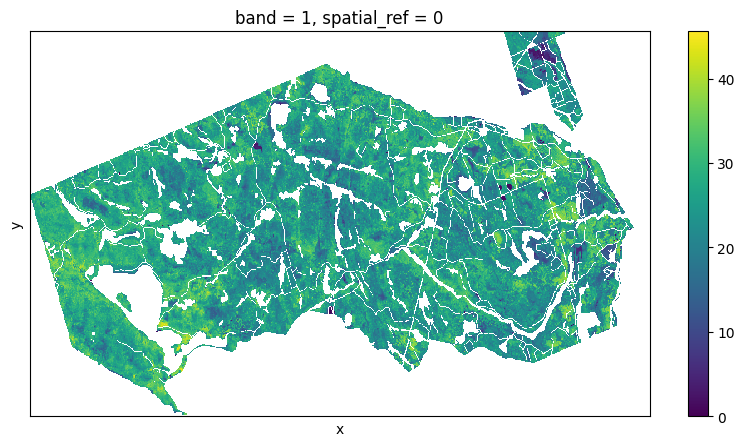

In [5]:
# Raster data: Visualize the LiDAR-derived 99th height percentile of the PRF
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_xticks([])
ax.set_yticks([])

p99.plot(ax=ax)

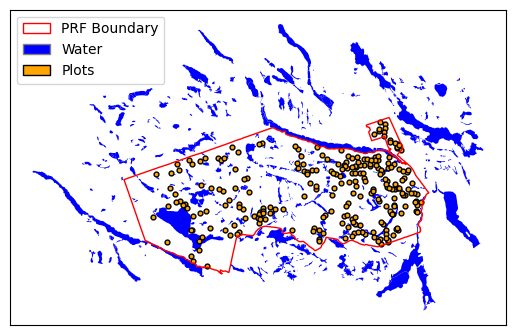

In [6]:
# Vector data: Visualize the plots and PRF boundary

plots_gdf = gpd.read_file(r'data/plots.gpkg')
boundary_gdf = gpd.read_file(r'data/boundary.gpkg')
water_gdf = gpd.read_file(r'data/water.gpkg')

ax = water_gdf.plot(color = 'blue')
plots_gdf.plot(ax = ax, facecolor='orange', edgecolor='black', markersize=12)
boundary_gdf.plot(ax = ax, facecolor = 'none', edgecolor = 'red')

legend_items = [Patch(facecolor='none', edgecolor='r', label='PRF Boundary'),
                Patch(facecolor='blue', edgecolor='grey', label='Water'),
                Patch(facecolor='orange', edgecolor='black', label='Plots')]

ax.legend(handles=legend_items, loc='upper left')
ax.set_xticks([])
ax.set_yticks([])


plt.show()


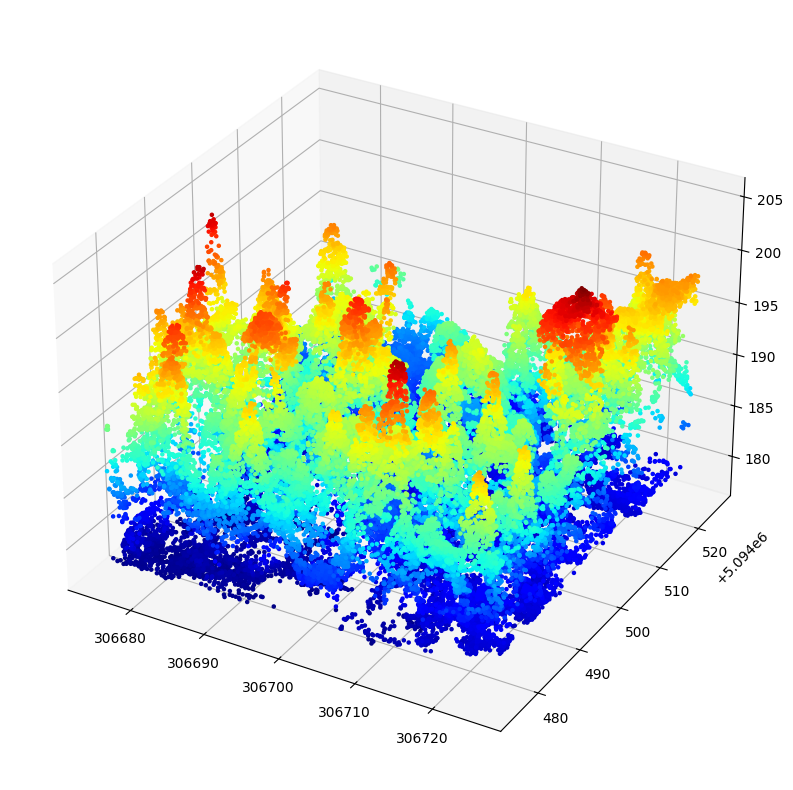

In [7]:
# Point Cloud (3D - LiDAR data)

las = laspy.read(r'data/forest_point_cloud.las')

pc = np.vstack([las.x, las.y, las.z]).transpose()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(pc[:, 0],
            pc[:, 1],
            pc[:, 2],
            c=pc[:, 2],
            cmap='jet',
            linewidth=1,
            alpha=1,
            s=5)

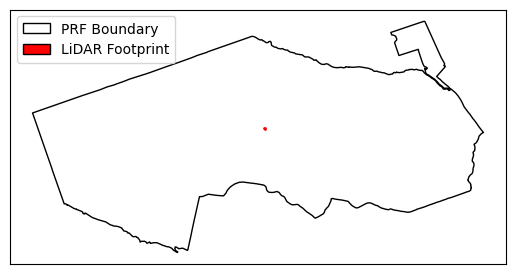

In [17]:
# View the lidar footprint within the PRF

lidar_footprint = gpd.read_file(r'data/forest_point_cloud_footprint.gpkg')

boundary_gdf = gpd.read_file(r'data/boundary.gpkg')

ax = boundary_gdf.plot(facecolor = 'none', edgecolor = 'black')
lidar_footprint.plot(ax = ax, edgecolor='red', markersize=12, linewidth=2)


legend_items = [Patch(facecolor='none', edgecolor='black', label='PRF Boundary'),
                Patch(facecolor='red', edgecolor='black', label='LiDAR Footprint')]

ax.legend(handles=legend_items, loc='upper left')
ax.set_xticks([])
ax.set_yticks([])


plt.show()